In [1]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from tqdm import tqdm
from random import randint
from tqdm.auto import tqdm
from scipy.stats import entropy
import time
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (20, 16)
warnings.simplefilter("ignore")

In [2]:
current_dataset = 5
name_directory = "../Downloads/UTC-13"
path = os.path.join(name_directory,str(current_dataset))
os.listdir(path)

['botnet-capture-20110815-fast-flux.pcap',
 'capture20110815-2.binetflow',
 'e4f816462c4fc84bb250e2b1d295bf23_85f9a5247afbe51e64794193f1dd72eb_unpacked.exe',
 'README']

In [3]:
[i for i in os.listdir(path) if i.endswith(".binetflow") ]

['capture20110815-2.binetflow']

In [4]:
datafile_name = [i for i in os.listdir(path) if i.endswith(".binetflow") ][0]
df = pd.read_csv(os.path.join(path,datafile_name))
df

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/15 16:43:28.078942,0.000000,tcp,114.33.245.44,6881,?>,147.32.84.118,1567,RA_,0.0,0.0,1,60,60,flow=Background
1,2011/08/15 16:43:32.283576,13.431962,tcp,212.93.105.52,49237,->,147.32.84.229,80,SRA_SA,0.0,0.0,6,388,208,flow=Background-TCP-Established
2,2011/08/15 16:43:32.456441,13.350228,tcp,212.93.105.52,14906,->,147.32.84.229,13363,SRA_SA,0.0,0.0,6,388,208,flow=Background-TCP-Established
3,2011/08/15 16:43:32.850648,13.010090,tcp,212.93.105.52,60349,->,147.32.84.229,443,SRA_SA,0.0,0.0,6,388,208,flow=Background-TCP-Established
4,2011/08/15 16:45:09.305002,20.990047,tcp,115.127.24.116,3198,->,147.32.84.229,443,SR_SA,0.0,0.0,5,308,122,flow=Background-TCP-Established
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129827,2011/08/15 17:13:26.665269,0.020175,tcp,147.32.84.59,1121,->,147.32.80.13,80,SPA_SPA,0.0,0.0,5,1070,726,flow=To-Background-CVUT-Proxy
129828,2011/08/15 17:13:26.715751,0.000306,udp,147.32.86.20,63044,<->,147.32.80.9,53,CON,0.0,0.0,2,261,84,flow=To-Background-UDP-CVUT-DNS-Server
129829,2011/08/15 17:13:26.716285,0.076739,tcp,147.32.86.20,1311,->,188.138.84.239,80,SPA_SA,0.0,0.0,10,3639,429,flow=Background-TCP-Established
129830,2011/08/15 17:13:26.721279,0.000244,tcp,78.94.167.118,65017,->,147.32.84.118,6881,S_RA,0.0,0.0,2,134,74,flow=Background-TCP-Attempt


Données:
- Start time: Date/heure de début du flux
- Durée: Temps écoulé entre le début et la fin du flux
- Proto: Protocole utilisé pour l'échange
- SrcAddr/DstAddr: Adresses source et destination
- Sport/Dport: Ports source et destination
- Dir: Direction des flux (source vers destination, destination vers source ou les deux)
- State: Etat de la connection: accès à distance (RA), accès à distance sécurisé (SRA) ...
- sTos/dTos:
- TotPkts/TotBytes: Nombre total de packets/Bytes échangés au cours de la durée de l'échange
- SrcBytes:

In [5]:
#Calcul du volume total de trafic en Octets
def vol_df(df):
    vol_total = 0
    for i in df['TotBytes']:
        vol_total += i
    return vol_total

print("- Volume total de trafic pour le dataset:", round(vol_df(df)/1000000000,2), "Giga Octets.")

#Durée moyenne des connexions
def duree_moy_con(df):
    duree_total_con = 0
    for i in df['Dur']:
        duree_total_con += i
    return duree_total_con/len(df['Dur'])

print("- Durée moyenne des connexions pour le dataset:", round(duree_moy_con(df)/60,2), "minutes.")

- Volume total de trafic pour le dataset: 3.74 Giga Octets.
- Durée moyenne des connexions pour le dataset: 1.29 minutes.


In [6]:
#Nombre moyen de connexions par IP
def moy_conn_IP(df):
    dic_moy_IP = {}
    for i in range(0, len(df['Dur'])):
        if(df.iloc[i]['SrcAddr'] not in dic_moy_IP):
            dic_moy_IP[df.iloc[i]['SrcAddr']] = 0
        dic_moy_IP[df.iloc[i]['SrcAddr']] += 1
        if(df.iloc[i]['DstAddr'] not in dic_moy_IP):
            dic_moy_IP[df.iloc[i]['DstAddr']] = 0
        dic_moy_IP[df.iloc[i]['DstAddr']] += 1
    nb_moy_conn_IP = 0
    for key in dic_moy_IP:
        nb_moy_conn_IP += dic_moy_IP[key]
    return nb_moy_conn_IP/len(dic_moy_IP)
print("- Nombre moyen de connexions par IP:", round(moy_conn_IP(df),2))

- Nombre moyen de connexions par IP: 6.23


In [7]:
#Répartition du trafic par protocole
def repart_traf_par_proto(df):
    dic_traf_proto = {}
    for i in range(0, len(df['Dur'])):
        if(df.iloc[i]['Proto'] not in dic_traf_proto):
            dic_traf_proto[df.iloc[i]['Proto']] = 0
        dic_traf_proto[df.iloc[i]['Proto']] += df.iloc[i]['TotBytes']
    traf_tot = vol_df(df)
    for key in dic_traf_proto:
        dic_traf_proto[key] = round(dic_traf_proto[key]/traf_tot,4)
    print("done")
    return dic_traf_proto
repart_traf_proto = repart_traf_par_proto(df)
print("- Répartition du trafic par protocole:", repart_traf_proto)

done
- Répartition du trafic par protocole: {'tcp': 0.9804, 'udp': 0.0191, 'icmp': 0.0004, 'ipx/spx': 0.0, 'arp': 0.0, 'rtcp': 0.0, 'rtp': 0.0, 'pim': 0.0, 'igmp': 0.0, 'ipv6-icmp': 0.0, 'rsvp': 0.0}


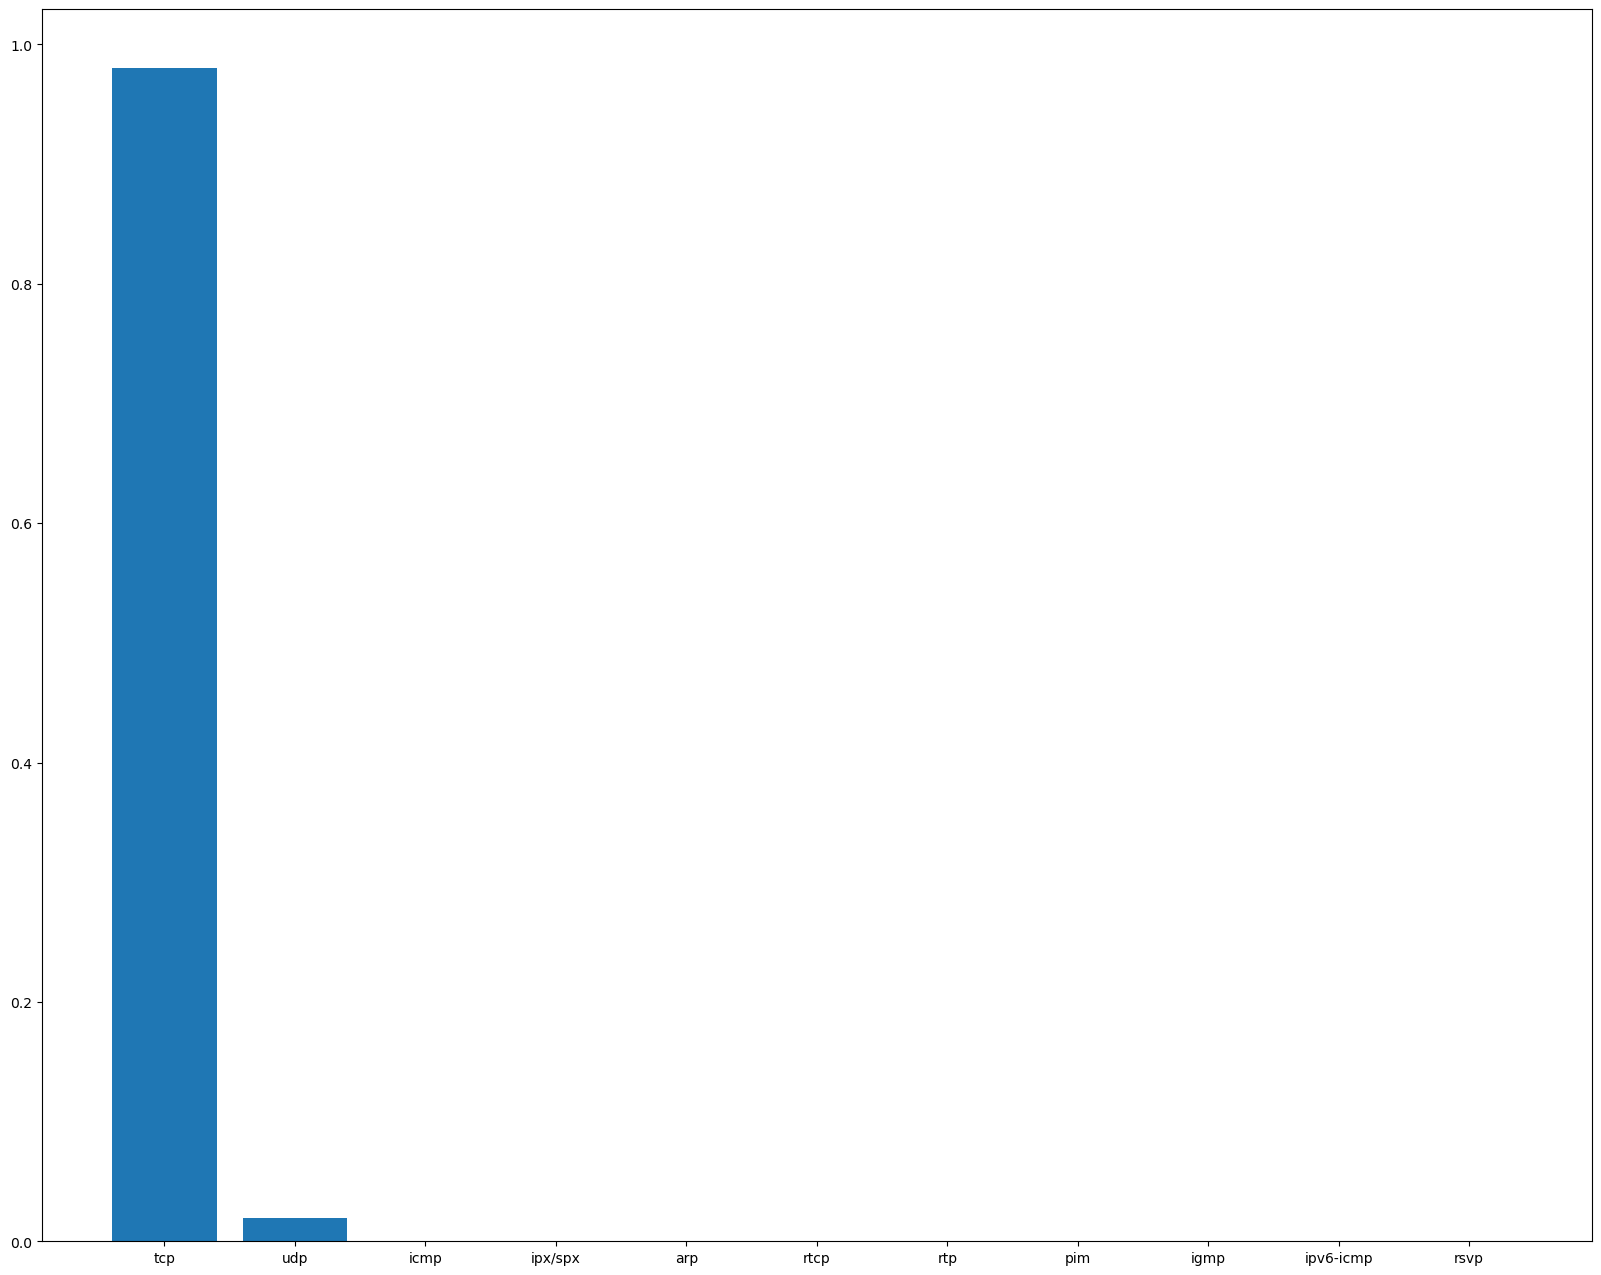

In [9]:
#Génération du graphique associé
x = list(repart_traf_proto.keys())
y = list(repart_traf_proto.values())

fix, ax = plt.subplots()
ax.bar(x, height=y)
plt.show()

<AxesSubplot:>

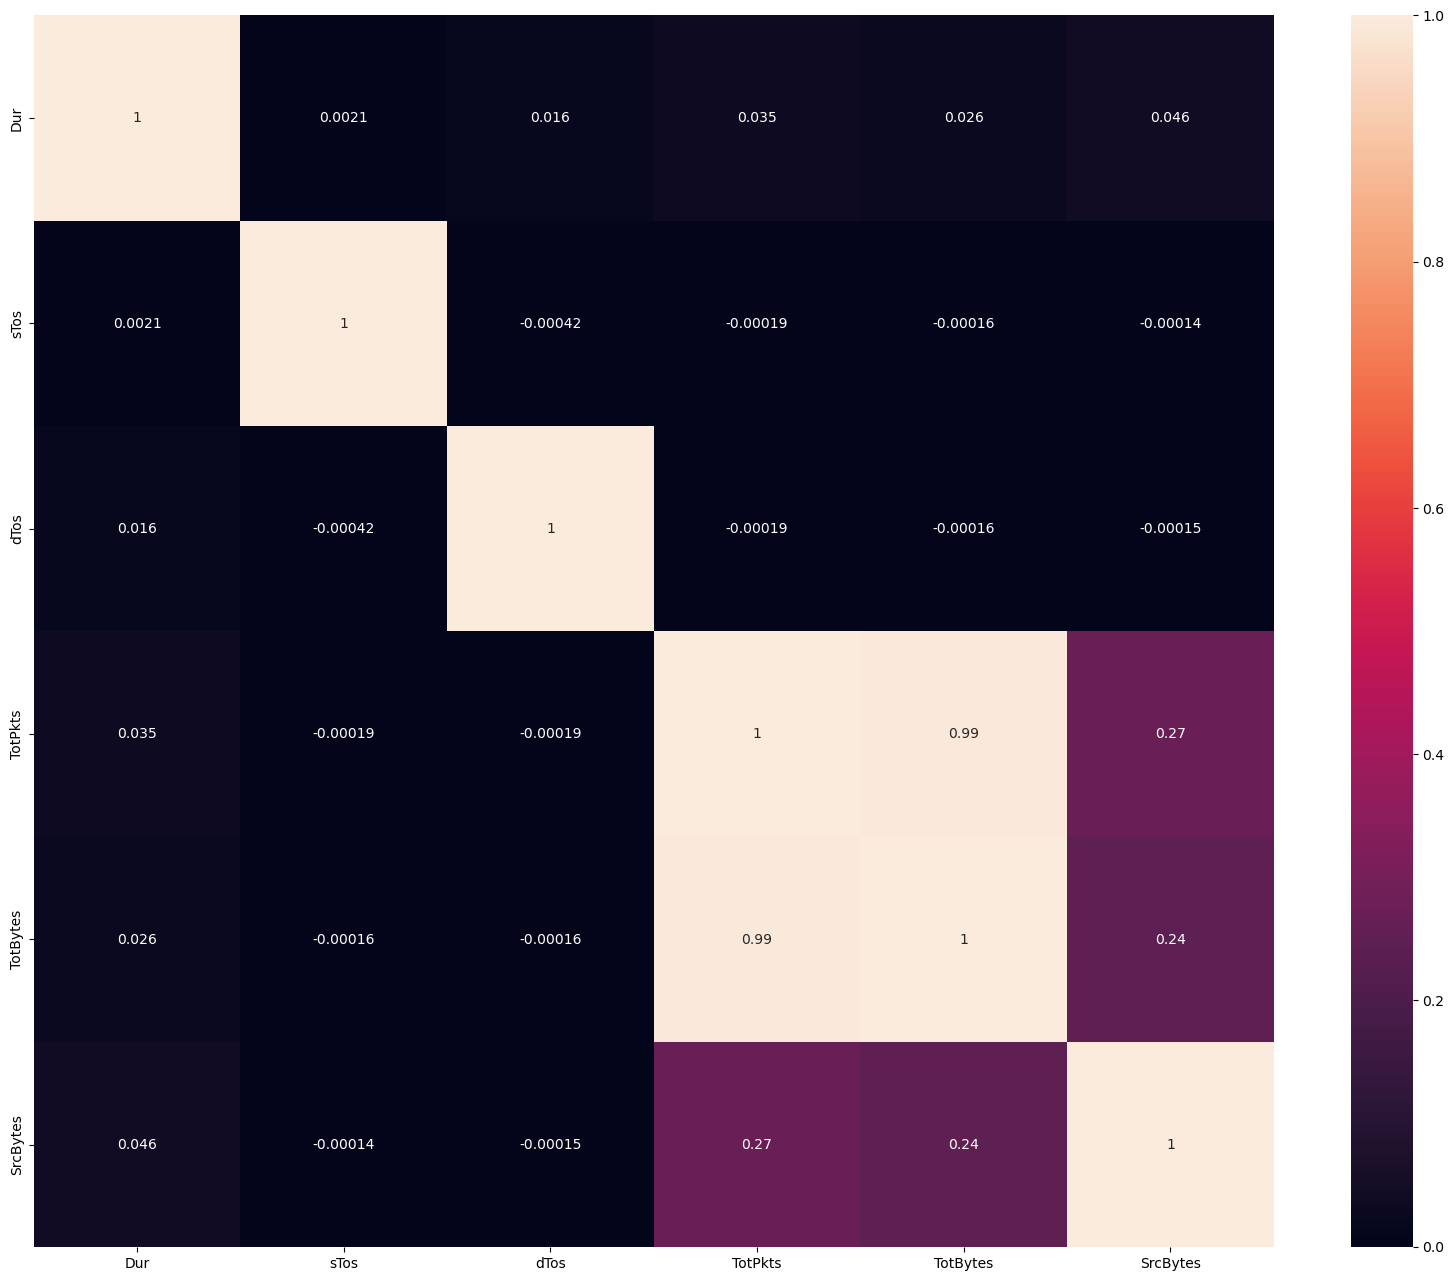

In [10]:
#Matrice de corrélation

corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True)

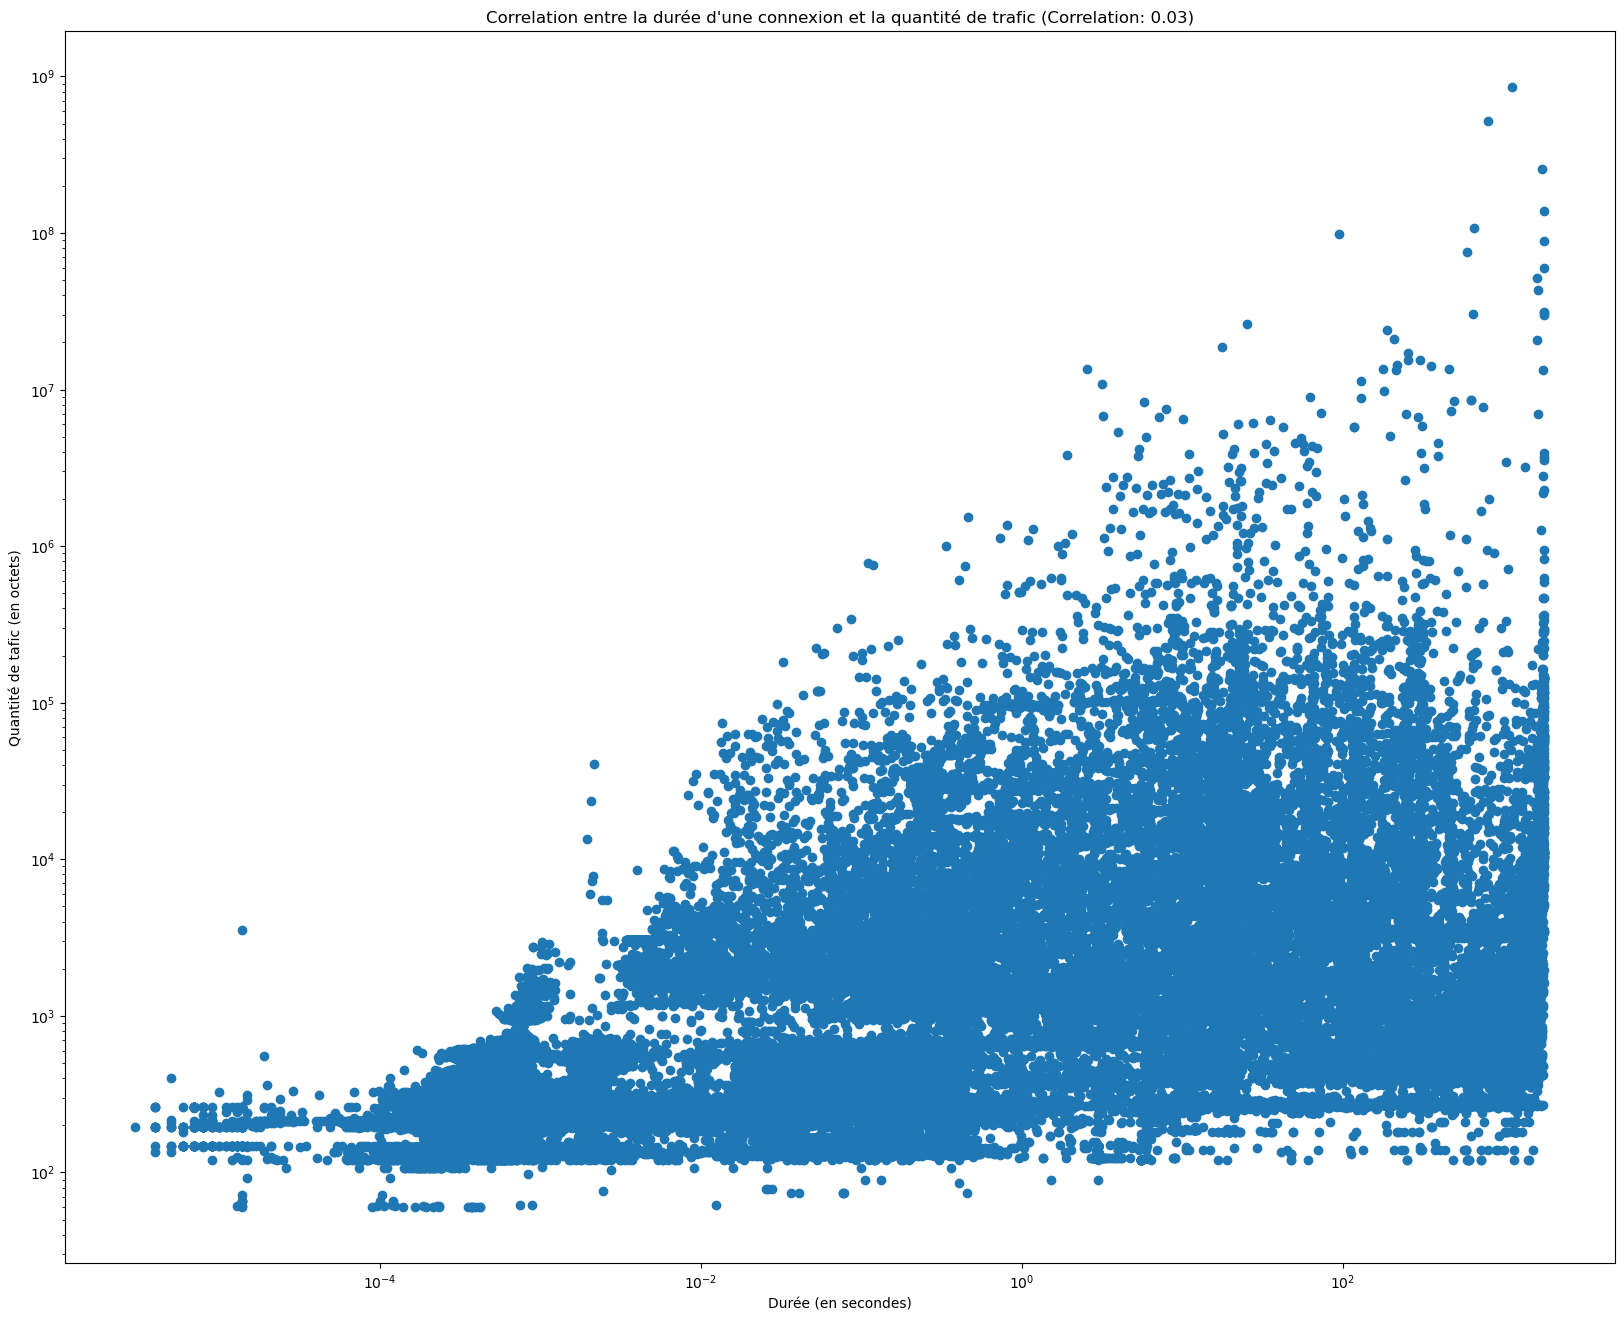

In [14]:
#Analyse de correlation entre le volume de trafic et la durée des connexions
corr_value = df['Dur'].corr(df['TotBytes'])

fig, ax = plt.subplots()
ax.scatter(df['Dur'], df['TotBytes'])

# Set the x-axis and y-axis to logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(f"Correlation entre la durée d'une connexion et la quantité de trafic (Correlation: {corr_value:.2f})")
plt.xlabel("Durée (en secondes)")
plt.ylabel("Quantité de tafic (en octets)")

plt.show()

In [15]:
#Test: la connexion avec le plus de trafic est-elle labélisée comme botnet?
max = 0
j = 0
for i in range(0, len(df['Dur'])):
    if df.iloc[i]['TotBytes']>max:
        max = df.iloc[i]['TotBytes']
        j = 1
print(df.iloc[j]['Label'])
print("La donnée n'est pas labélise comme un botnet")

flow=Background-TCP-Established
La donnée n'est pas labélise comme un botnet
